# Find initial conditions for $$a_0$$ by inverting the KdV model

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import h5py

from scipy import signal
from scipy.optimize import minimize
from scipy.interpolate import interp1d

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince

#from iwaves.kdv.solve import solve_kdv
from iwaves.kdv.vkdv import  vKdV
from iwaves.utils import imodes
from iwaves.utils import density


import matplotlib as mpl

import yaml

In [3]:
%matplotlib notebook

In [4]:
# KdV function
def zeroic(x, a_0, L_w, x0=0.):
    return 0*x

def bcfunc_old(t):
    omega = 2*np.pi/(12.42*3600.)
    return -a0*np.sin(omega*t)

def bcfunc(amp, frq, t, t0, ramptime):
    #omega = 2*np.pi/(12.42*3600.)
    nf = len(frq)
    a = 0.
    for nn in range(nf):
        a += amp[nn]*np.cos(frq[nn]*t) + amp[nn+nf]*np.sin(frq[nn]*t)
    
    rampfac = 1 - np.exp(-(t-t0)/ramptime)
    #print(t,t0, a, rampfac, a*rampfac)
    return a*rampfac


def start_kdv(infile, rho, z, depthfile):
    # Parse the yaml file
    with open(infile, 'r') as f:
        args = yaml.load(f)

        kdvargs = args['kdvargs']
        kdvargs.update({'wavefunc':zeroic})
        kdvargs.update({'verbose':False})
        #kdvargs.update({'nonlinear':False}) # Testing


        runtime = args['runtime']['runtime']
        ntout = args['runtime']['ntout']
        xpt =  args['runtime']['xpt']


    # Parse the density and depth files
    depthtxt = np.loadtxt(depthfile, delimiter=',')

    # Initialise the KdV class
    mykdv = vKdV(rho,\
        z,\
        depthtxt[:,1],\
        x=depthtxt[:,0],\
        **kdvargs)

    return mykdv


def run_vkdv(a0, frq, t0, runtime, mykdv, infile, verbose=True, ramptime=12*3600.):
    
    # Need to reset the amplitude variables and time step
    mykdv.B *= 0 
    mykdv.B_n_m1 *= 0
    mykdv.B_n_m2 *= 0
    mykdv.B_n_p1 *= 0
    mykdv.t = t0*1
    
    with open(infile, 'r') as f:
        args = yaml.load(f)

        kdvargs = args['kdvargs']
        kdvargs.update({'wavefunc':zeroic})

        #runtime = args['runtime']['runtime']
        ntout = args['runtime']['ntout']
        xpt =  args['runtime']['xpt']
        
    # Find the index of the output point
    idx = np.argwhere(mykdv.x > xpt)[0][0]

    # Initialise an output array
    nsteps = int(runtime//mykdv.dt_s)
    nout = int(runtime//ntout)
    B = np.zeros((nout, mykdv.Nx)) # Spatial amplitude function
    tout = np.zeros((nout,))

    B_pt = np.zeros((nsteps, )) # Spatial amplitude function
    tfast = np.zeros((nsteps,))

    output = []

    ## Run the model
    nn=0
    for ii in range(nsteps):
        # Log output
        point = nsteps//100
        bcleft = bcfunc(a0, frq, mykdv.t, t0, ramptime)
        
        if verbose:
            if(ii % (5 * point) == 0):
                print( '%3.1f %% complete...'%(float(ii)/nsteps*100)) 
                print(mykdv.B.max(), bcleft)

        if mykdv.solve_step(bc_left=bcleft) != 0:
            print( 'Blowing up at step: %d'%ii)
            break
        
        ## Evalute the function
        #if myfunc is not None:
        #    output.append(myfunc(mykdv))

        # Output data
        if (mykdv.t%ntout) < mykdv.dt_s:
            #print ii,nn, mykdv.t
            B[nn,:] = mykdv.B[:]
            tout[nn] = mykdv.t
            nn+=1

        # Output single point
        B_pt[ii] = mykdv.B[idx]
        tfast[ii] = mykdv.t

    # Save to netcdf
    ds = mykdv.to_Dataset()
    
    xray = xr

    # Create a dataArray from the stored data
    coords = {'x':mykdv.x, 'time':tout}
    attrs = {'long_name':'Wave amplitude',\
            'units':'m'}
    dims = ('time','x')

    Bda = xray.DataArray(B,
            dims = dims,\
            coords = coords,\
            attrs = attrs,\
        )

    coords = {'timefast':tfast}
    attrs = {'long_name':'Wave Amplitude Point',
            'units':'m',
            'x-coord':xpt}
    dims = ('timefast',)
    Bpt = xray.DataArray(B_pt,
            dims = dims,\
            coords = coords,\
            attrs = attrs,\
        )

    ds2 = xray.Dataset({'B_t':Bda,'B_pt':Bpt})
    #return ds2.merge( ds, inplace=True )
    #return ds.merge(ds2, inplace=True)
    #return ds.merge( xray.Dataset({'B_t':Bda,'B_pt':Bpt}), inplace=False )
    
    return ds2.merge( ds )




In [35]:
def myround(x, base=12*3600):
    return base * np.ceil(float(x)/base)

def init_kdv_inversion(ds, depthfile, infile, t1, t2, mode, basetime=datetime(2016,1,1)):
    """
    Initialise the boundary conditions and the vKdV class for performing boundary condition
    inversion (optimization) calculations
    """
    
    # Get the time series of A(t)
    A_obs = ds['A_n'].sel(time=slice(t1,t2), modes=mode)
    
    # Get the density at the start of the time
    rho = ds['rhobar'].sel(timeslow=t1, method='nearest')
    
    # Load the depth data
    depthtxt = np.loadtxt(depthfile, delimiter=',')
    z = np.arange(-depthtxt[0,1],5,5)[::-1]
    
    # Get the density model parameters from the density profile
    iw = imodes.IWaveModes(rho.values[::-1], rho.z.values[::-1], \
            density_class=density.FitDensity, density_func='double_tanh')

    iw(-250,5,mode)

    density_params = iw.Fi.f0

    rhonew = density.double_tanh_rho(z, *density_params)
    
    
    # Launch a KdV instance
    mykdv =  start_kdv(infile, rhonew, z, depthfile)
    
    # Find the observation location
    with open(infile, 'r') as f:
        args = yaml.load(f)
        xpt =  args['runtime']['xpt']

    # Find the index of the output point
    xpt = np.argwhere(mykdv.x > xpt)[0][0]
    
    # Compute the travel time and the wave amplification factor 
    ampfac = 1/np.sqrt(mykdv.Qterm)

    twave = np.cumsum(1/mykdv.c1*mykdv.dx)
    
    # Compute the phase and amplitude of the signal
    At = timeseries(A_obs.time.values, A_obs.values)
    amp, phs, frq, _, Afit, _ = At.tidefit(frqnames=['M2','M4','M6'], basetime=basetime)
    
    # Now we need to scale the amplitude and phase for the boundary (linear inversion)
    phs_bc = 1*phs
    amp_bc = 1*amp
    for ii in range(3):
        phs_bc[ii] = phs[ii] - twave[xpt]*frq[ii]
        amp_bc[ii] = amp[ii] / ampfac[xpt]

    amp_re = amp_bc*np.cos(phs_bc)
    amp_im = amp_bc*np.sin(phs_bc)
    
    # Set the time in the model to correspond with the phase of the boundary forcing
    ## Start time: round up to the near 12 hours from the wave propagation time plus the ramp time


    ramptime = 6*3600.
    bctime = myround(twave[xpt]+ramptime)

    starttime = datetime.strptime(t1, '%Y-%m-%d %H:%M:%S')
    endtime = datetime.strptime(t2, '%Y-%m-%d %H:%M:%S')

    starttime_sec = (starttime - basetime).total_seconds() 

    runtime = (endtime - starttime).total_seconds() 

    #twave[xpt]+ramptime, bctime, runtime, starttime_sec
    
    # Testing only
    #ds2 = run_vkdv( np.hstack([amp_re,amp_im]), frq, starttime_sec-bctime, runtime+bctime, 
    #    mykdv, infile, verbose=False, ramptime=ramptime)
    
    # Input variables for the vKdV run
    # a0, frq, t0, runtime, 
    a0 = np.hstack([amp_re,amp_im])
    
    t0 = starttime_sec-bctime
    
    runtime = runtime+bctime
    
    return mykdv, At, a0, frq, t0, runtime, density_params, twave[xpt], ampfac[xpt]



In [36]:
def single_run(a0, frq, t0, runtime,  At, mykdv, infile):
    
    ds2 = run_vkdv(a0, frq, t0, runtime, mykdv, infile, verbose=False)
    
    tobs_sec = SecondsSince(At.t, basetime=basetime)
    F = interp1d(ds2.timefast, ds2.B_pt, bounds_error=False)
    Amod = F(tobs_sec)
    
    return ds2, Amod, tobs_sec
    
def fdiff(a0, frq, t0, runtime,  At, mykdv, infile):

    ds2, Amod, tobs_sec = single_run(a0, frq, t0, runtime,  At, mykdv, infile)
    err = np.linalg.norm(At.y - Amod)
    
    #print(a0, err)
    
    # Return the L2-norm of the error vector
    return err

def print_result(xk):
    print(xk)

In [50]:
# Load the amplitude and density time-series data
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion_unvenfilt.nc'
depthfile = '../data/kdv_bathy_Prelude.csv'
infile = '../data/kdvin.yml'

sitename = 'CRUX_KP150'
outpath = '../output/vkdv_optimization'

ds = xr.open_dataset(ncfile, group='KP150_phs2')

ds

<xarray.Dataset>
Dimensions:   (freqs: 3, modes: 4, time: 271889, timeslow: 756, z: 100)
Coordinates:
  * modes     (modes) int64 0 1 2 3
  * time      (time) datetime64[ns] 2016-10-31T06:40:00 ... 2017-05-08T02:08:00
  * z         (z) float64 0.0 -2.525 -5.051 -7.576 ... -244.9 -247.5 -250.0
  * timeslow  (timeslow) datetime64[ns] 2016-10-31T06:40:00 ... 2017-05-08T00:40:00
  * freqs     (freqs) float64 0.0001405 0.000281 0.0004216
Data variables:
    Atide     (time, modes) float64 ...
    phi       (timeslow, modes, z) float64 ...
    rhofit    (time, z) float64 ...
    r10       (timeslow, modes) float64 ...
    rhobar    (timeslow, z) float64 ...
    amp       (timeslow, modes, freqs) float64 ...
    phs       (timeslow, modes, freqs) float64 ...
    A_n       (time, modes) float64 ...
    N2        (timeslow, z) float64 ...
    cn        (timeslow, modes) float64 ...
Attributes:
    Y:            -13.75897
    ncfile:       /home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Gridd...
    group:        KP150_phs2
    Description:  Linear vertical mode fit to KISSME mooring data
    X:            123.34613

In [38]:
# t1,t2 = '2017-04-02 00:00:00','2017-04-03 00:00:00'
# tmid = '2017-04-02 00:00:00'
# mode = 0
# basetime = datetime(2016,1,1)

t1,t2 = '2017-04-12 00:00:00','2017-04-13 00:00:00'
tmid = '2017-04-12 00:00:00'
mode = 0
basetime = datetime(2016,1,1)

In [39]:
# Testing
mykdv, At, a0, frq, t0, runtime, density_params, twave, ampfac = \
    init_kdv_inversion(ds, depthfile, infile, t1, t2, mode, basetime=basetime)

mykdv, At, a0, frq, t0, runtime

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


(<iwaves.kdv.vkdv.vKdV at 0x7f124646ffd0>,
 masked_array(data=[ 10.45016085,   4.23236996,   0.86417201, -12.50519527,
                      1.19702103,   1.81762013],
              mask=False,
        fill_value=1e+20),
 [0.00014051890250864362, 0.00028103780501728725, 0.00042155670752593087],
 40219200.0,
 216000.0)

In [69]:
# Minimize
soln = minimize(fdiff, a0, 
        args = (frq, t0, runtime, At, mykdv, infile),
        callback=print_result,
        method='SLSQP', options={'eps':1e-1, 'ftol':1e-2,'maxiter':1},
        #method='L-BFGS-B', options={'eps':1e-2, 'ftol':1e-2}    
        #method='Powell', options={'xtol':1e-2, 'ftol':1e-2}
        #method='CG',options={'eps':1e-4, 'gtol':1e-2}
        )

# Re-run the solution with the best-fit
ds2, Amod, t = single_run( soln['x'], frq, t0,  runtime, At, mykdv, infile)

[ 11.9996132  -12.82534099  -6.80302777 -18.62538878   1.62634977
 -10.95521117]
[ 10.90478151  -0.7724872   -1.38544049 -14.30090482   1.32298922
  -1.930022  ]


<IPython.core.display.Javascript object>


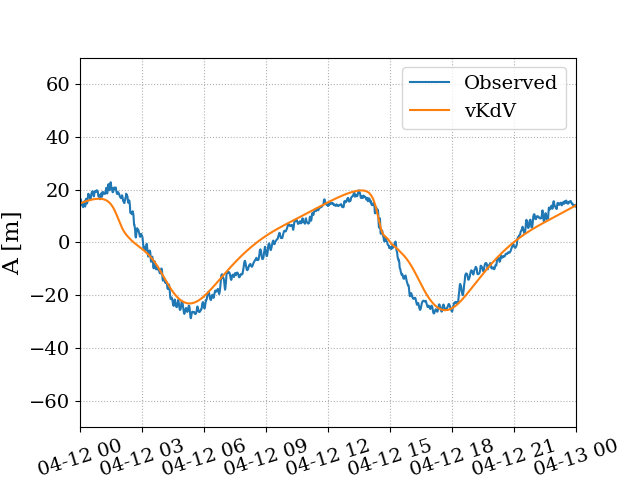

In [70]:
plt.figure()
#ds2.B_pt.plot()
plt.plot(At.t, At.y)
plt.plot(At.t, Amod)
plt.ylabel('A [m]')
plt.legend(('Observed','vKdV'))
plt.xticks(rotation=17)
plt.ylim(-70,70)
plt.xlim(At.t[0],At.t[-1])
plt.grid(b=True,ls=':')

In [63]:
# Save the optimized results and the important inputs in one netcdf file
soln['x'], a0, frq, At, Amod, t0, runtime, density_params, twave, ampfac, t1,t2,basetime
At.t.astype(int) 

h5file = '{}/vkdv_params_{}_{}.h5'.format(outpath,sitename,t1[0:10])
print('Wrote inputs to: ', h5file)
with h5py.File(h5file, "w") as f:
    f['a0_init'] = a0
    f['a0_opt'] = a0
    f['frq'] = frq
    f['A_obs'] = At.y
    f['A_mod'] = Amod
    f['density_params'] = density_params
    f['time_obs'] = At.t.astype(int)
    f['t0'] = t0
    f['t1'] = t1
    f['t2'] = t2
    f['twave'] = twave
    f['ampfac'] = ampfac
    f['basetime'] = datetime.strftime(basetime,'%Y-%m-%d %H:%M:%S')
    #for name in f:
    #    print(name)
        
ncfile = '{}/vkdv_soln_{}_{}.nc'.format(outpath,sitename,t1[0:10])
print('Wrote solution to : ',ncfile)
ds2.to_netcdf(ncfile)

Wrote inputs to:  ../output/vkdv_optimization/vkdv_params_CRUX_KP150_2017-04-12.h5
Wrote solution to :  ../output/vkdv_optimization/vkdv_soln_CRUX_KP150_2017-04-12.nc


In [ ]:
# Write the kdv data to a netcdf file

# Testing stuff...

<IPython.core.display.Javascript object>


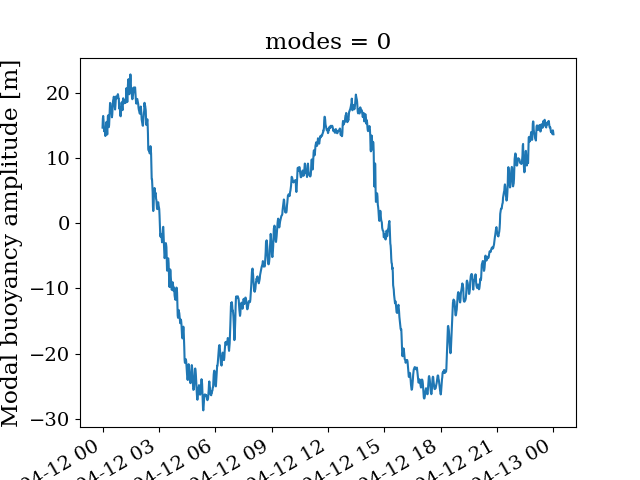

In [272]:
# Get the time series of A(t)
A_obs = ds['A_n'].sel(time=slice(t1,t2), modes=mode)

plt.figure()
A_obs.plot()

In [273]:
rho = ds['rhobar'].sel(timeslow=tmid, method='nearest')
rho

<xarray.DataArray 'rhobar' (z: 100)>
array([1021.322705, 1021.325808, 1021.329487, 1021.333852, 1021.339032,
       1021.345181, 1021.352479, 1021.361136, 1021.371397, 1021.383543,
       1021.397893, 1021.414807, 1021.434681, 1021.457943, 1021.48504 ,
       1021.516422, 1021.55252 , 1021.593709, 1021.640273, 1021.692358,
       1021.749931, 1021.812742, 1021.880304, 1021.951891, 1022.026571,
       1022.10326 , 1022.180804, 1022.258072, 1022.334041, 1022.407876,
       1022.478975, 1022.54699 , 1022.611822, 1022.67359 , 1022.732593,
       1022.789263, 1022.844121, 1022.897737, 1022.950698, 1023.00358 ,
       1023.056933, 1023.111264, 1023.167031, 1023.224633, 1023.284407,
       1023.346626, 1023.411494, 1023.479145, 1023.549641, 1023.622973,
       1023.699059, 1023.777747, 1023.858817, 1023.941985, 1024.026907,
       1024.113194, 1024.200413, 1024.288101, 1024.375778, 1024.46296 ,
       1024.549166, 1024.633934, 1024.716834, 1024.797468, 1024.875488,
       1024.950593, 1025.022537, 1025.091127, 1025.156225, 1025.217745,
       1025.275646, 1025.329935, 1025.380654, 1025.427879, 1025.471714,
       1025.512284, 1025.549731, 1025.584211, 1025.615886, 1025.644922,
       1025.67149 , 1025.695755, 1025.717882, 1025.738029, 1025.756349,
       1025.772988, 1025.788082, 1025.801763, 1025.81415 , 1025.825358,
       1025.83549 , 1025.844644, 1025.852909, 1025.860368, 1025.867095,
       1025.87316 , 1025.878626, 1025.88355 , 1025.887984, 1025.891977])
Coordinates:
  * z         (z) float64 0.0 -2.525 -5.051 -7.576 ... -244.9 -247.5 -250.0
    timeslow  datetime64[ns] 2017-04-12T00:40:00
Attributes:
    units:      kg m^-3
    long_name:  Background density

In [274]:
# Load the depth data
depthtxt = np.loadtxt(depthfile, delimiter=',')
z = np.arange(-depthtxt[0,1],5,5)[::-1]


<IPython.core.display.Javascript object>


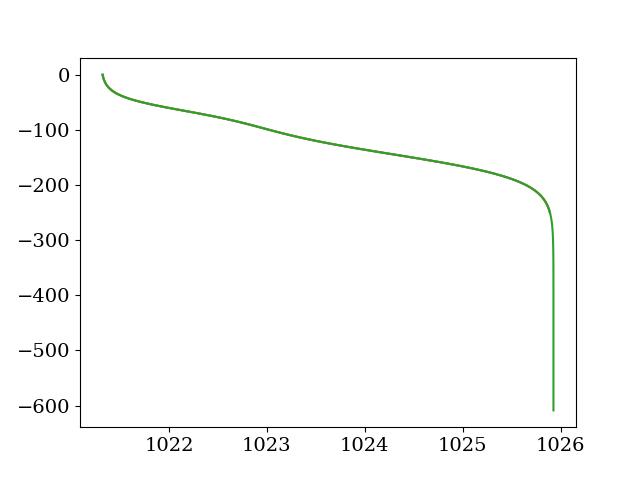

In [275]:
# Get the density model parameters from the density profile
iw = imodes.IWaveModes(rho.values[::-1], rho.z.values[::-1], \
        density_class=density.FitDensity, density_func='double_tanh')

iw(-250,5,mode)

density_params = iw.Fi.f0

rhonew = density.double_tanh_rho(z, *density_params)

# Check that everything is OK
plt.figure()
plt.plot(iw.rho, iw.z)
plt.plot(iw.rhoZ, iw.Z)
plt.plot(rhonew, z)

In [277]:
%%time
# Launch a KdV instance
mykdv =  start_kdv(infile, rhonew, z, depthfile)

CPU times: user 46.8 s, sys: 51.5 s, total: 1min 38s
Wall time: 25.3 s


In [278]:
# Find the observation location
with open(infile, 'r') as f:
        args = yaml.load(f)

        kdvargs = args['kdvargs']
        kdvargs.update({'wavefunc':zeroic})

        runtime = args['runtime']['runtime']
        ntout = args['runtime']['ntout']
        xpt =  args['runtime']['xpt']
        
# Find the index of the output point
xpt = np.argwhere(mykdv.x > xpt)[0][0]
xpt

2051

<IPython.core.display.Javascript object>


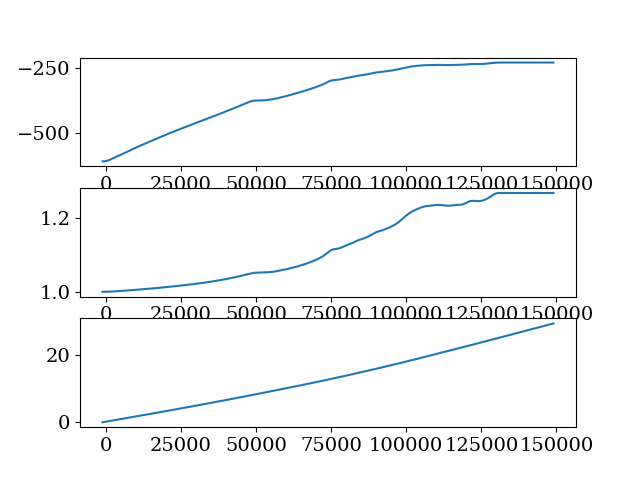

In [279]:
# Compute the travel time and the amplification factor and plot
ampfac = 1/np.sqrt(mykdv.Qterm)

twave = np.cumsum(1/mykdv.c1*mykdv.dx)

plt.figure()
plt.subplot(311)
plt.plot(mykdv.x, -mykdv.h)
plt.subplot(312)
plt.plot(mykdv.x, ampfac)

plt.subplot(313)
plt.plot(mykdv.x, twave/3600.)

/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


<IPython.core.display.Javascript object>


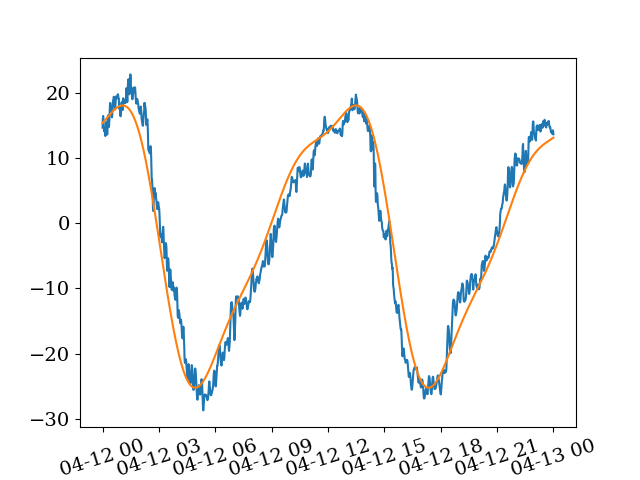

[0.00014051890250864362, 0.00028103780501728725, 0.00042155670752593087]

In [280]:
# Compute the phase and amplitude of the signal
At = timeseries(A_obs.time.values, A_obs.values)

amp, phs, frq, _, Afit, _ = At.tidefit(frqnames=['M2','M4','M6'], basetime=basetime)

plt.figure()
At.plot()
plt.plot(At.t, Afit)
frq

In [281]:
# Now we need to scale the amplitude and phase for the boundary
phs_bc = 1*phs
amp_bc = 1*amp
for ii in range(3):
    phs_bc[ii] = phs[ii] - twave[xpt]*frq[ii]
    amp_bc[ii] = amp[ii] / ampfac[xpt]
    
amp_re = amp_bc*np.cos(phs_bc)
amp_im = amp_bc*np.sin(phs_bc)

amp_re, amp_im, np.hstack([amp_re,amp_im])

(masked_array(data=[10.45016085242583, 4.232369958785777,
                    0.8641720095618872],
              mask=[False, False, False],
        fill_value=1e+20),
 masked_array(data=[-12.505195273669779, 1.1970210269556127,
                    1.8176201314613334],
              mask=[False, False, False],
        fill_value=1e+20),
 masked_array(data=[ 10.45016085,   4.23236996,   0.86417201, -12.50519527,
                      1.19702103,   1.81762013],
              mask=False,
        fill_value=1e+20))

In [282]:
# Set the time in the model to correspond with the phase of the boundary forcing
## Start time: round up to the near 12 hours from the wave propagation time plus the ramp time
def myround(x, base=12*3600):
    return base * np.ceil(float(x)/base)
              
ramptime = 6*3600.
bctime = myround(twave[xpt]+ramptime)

starttime = datetime.strptime(t1, '%Y-%m-%d %H:%M:%S')
endtime = datetime.strptime(t2, '%Y-%m-%d %H:%M:%S')

starttime_sec = (starttime - basetime).total_seconds() 

runtime = (endtime - starttime).total_seconds() 

twave[xpt]+ramptime, bctime, runtime, starttime_sec

(87833.66666782454, 129600.0, 86400.0, 40348800.0)

In [283]:
%%time
# Testing only
ds2 = run_vkdv( np.hstack([amp_re,amp_im]), frq, starttime_sec-bctime, runtime+bctime, 
            mykdv, infile, verbose=False, ramptime=ramptime)

ds2

CPU times: user 15.9 s, sys: 31.8 ms, total: 15.9 s
Wall time: 15.9 s


<xarray.Dataset>
Dimensions:   (time: 900, timefast: 14400, x: 3001, z: 123)
Coordinates:
  * x         (x) float64 -1e+03 -950.0 -900.0 ... 1.489e+05 1.49e+05 1.49e+05
  * time      (time) float64 4.022e+07 4.022e+07 ... 4.043e+07 4.044e+07
  * timefast  (timefast) float64 4.022e+07 4.022e+07 ... 4.044e+07 4.044e+07
  * z         (z) float64 -0.0 -4.99 -9.981 -14.97 ... -598.8 -603.8 -608.8
Data variables:
    B_t       (time, x) float64 -0.08667 -0.08155 -0.07644 ... 0.001127 0.0
    B_pt      (timefast) float64 0.0 0.0 0.0 0.0 0.0 ... 11.94 11.95 11.96 11.97
    B         (x) float64 -19.54 -19.5 -19.46 -19.55 ... 0.002255 0.001127 0.0
    Alpha     (x) float64 -0.008935 -0.008935 -0.008935 ... 0.001181 0.001181
    Beta      (x) float64 1.531e+04 1.531e+04 1.531e+04 ... 3.169e+03 3.169e+03
    Qterm     (x) float64 1.0 1.0 1.0 0.9999 ... 0.6227 0.6227 0.6227 0.6227
    r20       (x) float64 1.051e-05 1.051e-05 1.05e-05 ... 1.694e-05 1.694e-05
    h         (x) float64 608.8 608.8 608.8 608.8 ... 231.0 231.0 231.0 231.0
    Cn        (x) float64 1.799 1.799 1.799 1.799 ... 1.177 1.177 1.177 1.177
    X         (z, x) float64 -1e+03 -950.0 -900.0 ... 1.49e+05 1.49e+05
    Z         (z, x) float64 -0.0 -0.0 -0.0 -0.0 ... -231.0 -231.0 -231.0 -231.0
    rhoZ      (z, x) float64 1.021e+03 1.021e+03 ... 1.026e+03 1.026e+03
    Phi       (z, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    phi01     (z, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    phi10     (z, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    phi20     (z, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    D01       (z, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    D10       (z, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    D20       (z, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

<IPython.core.display.Javascript object>


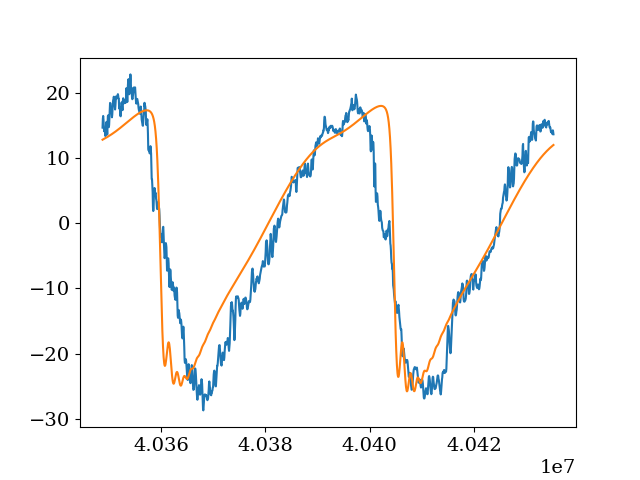

In [284]:
# Interpolate from the model to the observation
tobs_sec = SecondsSince(At.t, basetime=basetime)
F = interp1d(ds2.timefast, ds2.B_pt, bounds_error=False)
Amod = F(tobs_sec)

plt.figure()
plt.plot(tobs_sec, At.y)
plt.plot(tobs_sec, Amod)

In [286]:
%%time
# Testing only
#fdiff( 34.21820833, Amax, mykdv, infile,)
fdiff(np.hstack([amp_re,amp_im]), frq, starttime_sec-bctime, runtime+bctime, At, mykdv, infile)

[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 218.9358093627731
CPU times: user 16.2 s, sys: 38.2 ms, total: 16.3 s
Wall time: 16.4 s


218.9358093627731

In [296]:
# Minimize
a0guess = np.hstack([amp_re,amp_im])
soln = minimize(fdiff, a0guess, 
        args = (frq, starttime_sec-bctime, runtime+bctime, At, mykdv, infile),
        #method='SLSQP', options={'eps':1e-4, 'ftol':1e-2}
        #method='L-BFGS-B', options={'eps':1e-1, 'ftol':1e-2}    
        #method='Powell', options={'xtol':1e-1, 'ftol':1e-1}
        method='CG',options={'eps':1e-1, 'gtol':1e-2, maxiter=50}
        )

soln

[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 218.93578207810782
[ 10.55016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 218.78086396698393
[ 10.45016085   4.33236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 220.64158029710654
[ 10.45016085   4.23236996   0.96417201 -12.50519527   1.19702103
   1.81762013] 219.70252917947207
[ 10.45016085   4.23236996   0.86417201 -12.40519527   1.19702103
   1.81762013] 219.54782855273248
[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.29702103
   1.81762013] 218.8928763279005
[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.91762013] 220.21309233203817
[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 218.93580926718698
[ 10.51669985   3.49971125   0.53484587 -12.76807583   1.21544951
   1.26900162] 196.99129253688926
[ 10.51669985   3.49971125   0.53484587 -12.76807583   1.21544951
   1.26900162] 196.99129237799775
[

KeyboardInterrupt: 

In [301]:
# Minimize
a0guess = np.hstack([amp_re,amp_im])
soln = minimize(fdiff, a0guess, 
        args = (frq, starttime_sec-bctime, runtime+bctime, At, mykdv, infile),
        method='SLSQP', options={'eps':1e-1, 'ftol':1e-2,'maxiter':50}
        #method='L-BFGS-B', options={'eps':1e-2, 'ftol':1e-2}    
        #method='Powell', options={'xtol':1e-2, 'ftol':1e-2}
        #method='CG',options={'eps':1e-4, 'gtol':1e-2}
        )

soln

[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 218.93580883060613
[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 218.93580920192767
[ 10.55016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 218.78086396698393
[ 10.45016085   4.33236996   0.86417201 -12.50519527   1.19702103
   1.81762013] 220.64158029710654
[ 10.45016085   4.23236996   0.96417201 -12.50519527   1.19702103
   1.81762013] 219.70252917947207
[ 10.45016085   4.23236996   0.86417201 -12.40519527   1.19702103
   1.81762013] 219.54782855273248
[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.29702103
   1.81762013] 218.8928763279005
[ 10.45016085   4.23236996   0.86417201 -12.50519527   1.19702103
   1.91762013] 220.21309233203817
[ 11.9996132  -12.82534099  -6.80302777 -18.62538878   1.62634977
 -10.95521117] 608.2685157894465
[ 10.90478151  -0.7724872   -1.38544049 -14.30090481   1.32298922
  -1.930022  ] 166.4203405532804
[ 1

     fun: 142.28775855327547
     jac: array([ 0.15731203,  0.16994346,  0.26258945, -0.02396821,  0.17104284,
        0.18298573])
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([ 12.11566166,   0.08833526,  -0.852073  , -15.19712867,
         1.11221664,  -0.2460127 ])

<IPython.core.display.Javascript object>


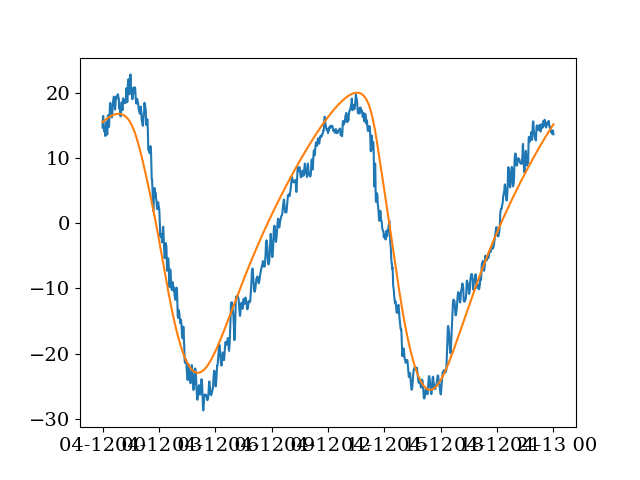

In [303]:
# ds2 = run_vkdv( soln['x'], frq, starttime_sec-bctime, runtime+bctime,  mykdv, infile)

ds2, Amod, t = single_run( soln['x'], frq, starttime_sec-bctime, runtime+bctime, At, mykdv, infile)

plt.figure()
#ds2.B_pt.plot()
plt.plot(At.t, At.y)
plt.plot(At.t, Amod)

<IPython.core.display.Javascript object>


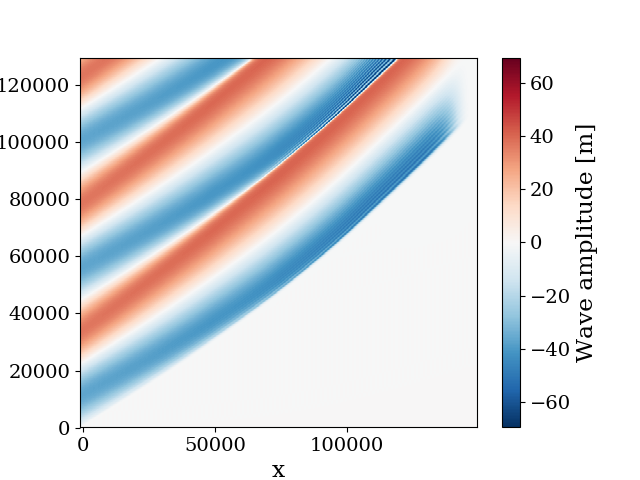

<xarray.Dataset>
Dimensions:   (time: 540, timefast: 8640, x: 3001, z: 123)
Coordinates:
  * x         (x) float64 -1e+03 -950.0 -900.0 ... 1.489e+05 1.49e+05 1.49e+05
  * time      (time) float64 240.0 480.0 720.0 ... 1.291e+05 1.294e+05 1.296e+05
  * timefast  (timefast) float64 15.0 30.0 45.0 ... 1.296e+05 1.296e+05
  * z         (z) float64 -0.0 -4.99 -9.981 -14.97 ... -598.8 -603.8 -608.8
Data variables:
    B_t       (time, x) float64 -1.168 -0.868 -0.5681 ... -0.000454 0.0
    B_pt      (timefast) float64 0.0 0.0 0.0 0.0 ... -19.56 -19.5 -19.44 -19.37
    B         (x) float64 22.05 22.24 22.44 22.67 ... -0.0009079 -0.000454 0.0
    Alpha     (x) float64 -0.007639 -0.007639 ... -0.0001103 -0.0001103
    Beta      (x) float64 1.53e+04 1.53e+04 1.53e+04 ... 2.977e+03 2.977e+03
    Qterm     (x) float64 1.0 1.0 1.0 0.9999 ... 0.5545 0.5545 0.5545 0.5545
    h         (x) float64 608.8 608.8 608.8 608.8 ... 231.0 231.0 231.0 231.0
    Cn        (x) float64 1.772 1.772 1.772 1.772 ..

In [85]:
plt.figure()
ds2.B_t.plot()
ds2

In [105]:
# Write to a file
outfile = '../data/kdv_optimal_a0_Prelude_%s.nc'%data['time'][tt].strftime('%Y-%m-%d')
ds2.to_netcdf(outfile)


-rwxrwxrwx 1 root root 36M Jun 12  2019 ../data/kdv_optimal_a0_Prelude_2017-04-03.nc


# Flat bottom optimizer

In [107]:
# Run the KdV solver
def runkdv(a0_sample, rho, z):
    def zeroic(x,a,L,x0=0):
        return 0*x

    kdvargs = dict(\
          verbose=False,\
          a0=a0_sample,\
          Lw=0.,\
          eigen_mde=eigen_mde,
          dt=20.,\
          nu_H=0.1,\
          ekdv=False,\
          wavefunc=zeroic,\
          spongedist = 10000.,\
          )
    #    print("p2 for a0 {}".format(a0_sample))
    omega = 2*np.pi/(12.42*3600)

    # No longer need this with zero initial conditions

    x_domain = np.arange(0,L_d+dx, dx)

    # Find the ouput x location
    xpt = np.argwhere(x_domain >= output_x)[0,0]

    # Boundary forcing function
    def sinebc(t):
        return a0_sample*np.sin(omega*t)

    # 8400 corresponds to the first grid point that is 1e5 meters away from
    # the initial point
    def amp_at_x(kdv):

        return kdv.B[xpt]

    #mykdv, B, output_amplitude = solve_kdv(iw_modes_output.rhoZ, iw_modes_output.Z, runtime,\
    mykdv, B, output_amplitude = solve_kdv(rho,
            z, 
            runtime,\
            solver='imex',\
            ntout=ntout, outfile=outfile,\
            x = x_domain,
            bcfunc=sinebc,
            myfunc=amp_at_x,\
            **kdvargs)
    
    return maximum_amplitude_finder(output_amplitude)


In [108]:
runkdv(35, rhobar.sel(timeslow='2017-04-01 00:00:00').values, rhobar.z.values)

NameError: name 'rhobar' is not defined

<IPython.core.display.Javascript object>


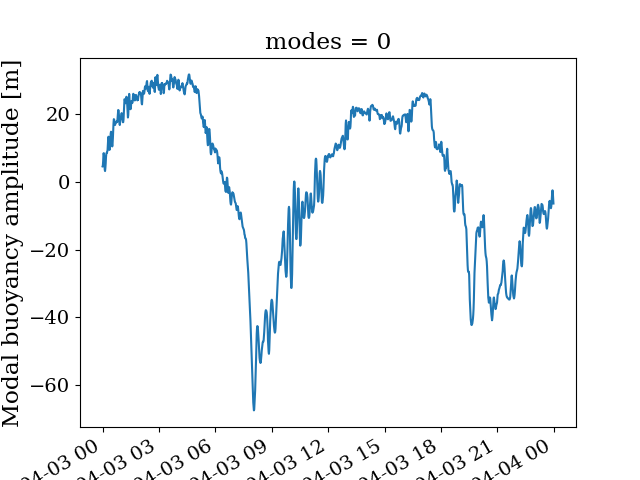

-67.60455940967898


In [107]:
Anow = A_n.sel(time='2017-04-03')
plt.figure()
Anow.plot()
print(maximum_amplitude_finder(Anow.values))


In [133]:
def fdiff(a0, A, rho, z):
    Amax = maximum_amplitude_finder(A.values)
    Aguess = runkdv(a0, rho, z)
    print(a0, Amax, Aguess )
    return (Aguess - Amax)**2.

#fdiff(30, A_n.sel(time='2017-04-01'),rhobar.sel(timeslow='2017-04-01 00:00:00').values, rhobar.z.values)

In [144]:
minimize(fdiff, [30], 
        args = (A_n.sel(time='2017-02-13'),rhobar.sel(timeslow='2017-02-14 00:00:00').values, rhobar.z.values),
        bounds=[(0,np.abs(maximum_amplitude_finder(A_n.sel(time='2017-02-13').values)) )],
        method='SLSQP', options={'eps':1e-4, 'ftol':1e-2}
        #method='CG',options={'eps':1e-4, 'gtol':1e-2}
        )

/home/suntans/code/iwaves/iwaves/kdv/solve.py:97: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.
  ds.merge( xray.Dataset({'B_t':Bda}), inplace=True )


[30.] -38.33124918310987 -30.049209481114485
[30.] -38.33124918310987 -30.049209481114485
[30.0001] -38.33124918310987 -30.049314410277695
[38.33124918] -38.33124918310987 -73.15153293740651
[30.83312492] -38.33124918310987 -30.92522346743914
[30.83312492] -38.33124918310987 -30.92522346743914
[30.83322492] -38.33124918310987 -30.92532892645022
[38.22774654] -38.33124918310987 -72.43582101100425
[31.57258708] -38.33124918310987 -31.752604079902195
[31.57258708] -38.33124918310987 -31.752604079902195
[31.57268708] -38.33124918310987 -31.752739068024106
[38.33124918] -38.33124918310987 -73.15153293738611
[32.24845329] -38.33124918310987 -33.502910731782315
[32.24845329] -38.33124918310987 -33.502910731782315
[32.24855329] -38.33124918310987 -33.5034015361953
[38.33124918] -38.33124918310987 -73.15153293740752
[32.85673288] -38.33124918310987 -36.631483392773234
[32.85673288] -38.33124918310987 -36.631483392773234
[32.85683288] -38.33124918310987 -36.632019620317514
[33.23684924] -38.3312

     fun: 0.00111838234653131
     jac: array([-0.3755506])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([33.16183621])

52.223896926957515